# CS 224D Assignment #2
# Part [1]: Deep Networks: NER Window Model

For this first part of the assignment, you'll build your first "deep" networks. On problem set 1, you computed the backpropagation gradient $\frac{\partial J}{\partial w}$ for a two-layer network; in this problem set you'll implement a slightly more complex network to perform  named entity recognition (NER).

Before beginning the programming section, you should complete parts (a) and (b) of the corresponding section of the handout.

In [1]:
import sys, os
from numpy import *
from matplotlib.pyplot import *
%matplotlib inline
matplotlib.rcParams['savefig.dpi'] = 100

%load_ext autoreload
%autoreload 2

## (c): Random Initialization Test
Use the cell below to test your code.

In [2]:
from misc import random_weight_matrix
random.seed(10)
print random_weight_matrix(3,5)

[[ 0.46994114 -0.83008197  0.23148553  0.43094097 -0.00258593]
 [-0.47666619 -0.52297046  0.45125243 -0.57311684 -0.71301636]
 [ 0.32105262  0.78530031 -0.85918681  0.02111762  0.54147539]]


## (d): Implementation

We've provided starter code to load in the dataset and convert it to a list of "windows", consisting of indices into the matrix of word vectors. 

We pad each sentence with begin and end tokens `<s>` and `</s>`, which have their own word vector representations; additionally, we convert all words to lowercase, canonicalize digits (e.g. `1.12` becomes `DG.DGDG`), and replace unknown words with a special token `UUUNKKK`.

You don't need to worry about the details of this, but you can inspect the `docs` variables or look at the raw data (in plaintext) in the `./data/` directory.

In [3]:
import data_utils.utils as du
import data_utils.ner as ner

In [4]:
# Load the starter word vectors
wv, word_to_num, num_to_word = ner.load_wv('data/ner/vocab.txt',
                                           'data/ner/wordVectors.txt')
tagnames = ["O", "LOC", "MISC", "ORG", "PER"]
num_to_tag = dict(enumerate(tagnames))
tag_to_num = du.invert_dict(num_to_tag)

# Set window size
windowsize = 3

# Load the training set
docs = du.load_dataset('data/ner/train')
X_train, y_train = du.docs_to_windows(docs, word_to_num, tag_to_num,
                                      wsize=windowsize)

# Load the dev set (for tuning hyperparameters)
docs = du.load_dataset('data/ner/dev')
X_dev, y_dev = du.docs_to_windows(docs, word_to_num, tag_to_num,
                                  wsize=windowsize)

# Load the test set (dummy labels only)
docs = du.load_dataset('data/ner/test.masked')
X_test, y_test = du.docs_to_windows(docs, word_to_num, tag_to_num,
                                    wsize=windowsize)

To avoid re-inventing the wheel, we provide a base class that handles a lot of the drudgery of managing parameters and running gradient descent. It's based on the classifier API used by [`scikit-learn`](http://scikit-learn.org/stable/), so if you're familiar with that library it should be easy to use. 

We'll be using this class for the rest of this assignment, so it helps to get acquainted with a simple example that should be familiar from Assignment 1. To keep this notebook uncluttered, we've put the code in the `softmax_example.py`; take a look at it there, then run the cell below.

In [5]:
from softmax_example import SoftmaxRegression
sr = SoftmaxRegression(wv=zeros((10,100)), dims=(100,5))

##
# Automatic gradient checker!
# this checks anything you add to self.grads or self.sgrads
# using the method of Assignment 1
sr.grad_check(x=5, y=4)

grad_check: dJ/db error norm = 3.565e-10 [ok]
    b dims: [5] = 5 elem
grad_check: dJ/dW error norm = 2.164e-11 [ok]
    W dims: [5, 100] = 500 elem
grad_check: dJ/dL[5] error norm = 2.646e-11 [ok]
    L[5] dims: [100] = 100 elem


In order to implement a model, you need to subclass `NNBase`, then implement the following methods:

- `__init__()` (initialize parameters and hyperparameters)
- `_acc_grads()` (compute and accumulate gradients)
- `compute_loss()` (compute loss for a training example)
- `predict()`, `predict_proba()`, or other prediction method (for evaluation)

`NNBase` provides you with a few others that will be helpful:

- `grad_check()` (run a gradient check - calls `_acc_grads` and `compute_loss`)
- `train_sgd()` (run SGD training; more on this later)

Your task is to implement the window model in `nerwindow.py`; a scaffold has been provided for you with instructions on what to fill in.

When ready, you can test below:

In [6]:
from nerwindow import WindowMLP
clf = WindowMLP(wv, windowsize=3, dims=[None, 100, 5],
                reg=0.001, alpha=0.01)
clf.grad_check(X_train[0], y_train[0]) # gradient check on single point

grad_check: dJ/db2 error norm = 3.233e-10 [ok]
    b2 dims: [5] = 5 elem
grad_check: dJ/dU error norm = 2.847e-10 [ok]
    U dims: [5, 100] = 500 elem
grad_check: dJ/db1 error norm = 2.849e-09 [ok]
    b1 dims: [100] = 100 elem
grad_check: dJ/dW error norm = 1.337e-08 [ok]
    W dims: [100, 150] = 15000 elem
grad_check: dJ/dL[30] error norm = 3.568e-11 [ok]
    L[30] dims: [50] = 50 elem
grad_check: dJ/dL[6659] error norm = 4.442e-11 [ok]
    L[6659] dims: [50] = 50 elem
grad_check: dJ/dL[12637] error norm = 4.6e-11 [ok]
    L[12637] dims: [50] = 50 elem


Now we'll train your model on some data! You can implement your own SGD method, but we recommend that you just call `clf.train_sgd`. This takes the following arguments:

- `X`, `y` : training data
- `idxiter`: iterable (list or generator) that gives index (row of X) of training examples in the order they should be visited by SGD
- `printevery`: int, prints progress after this many examples
- `costevery`: int, computes mean loss after this many examples. This is a costly operation, so don't make this too frequent!

In [7]:
nepoch = 5
N = nepoch * len(y_train)
k = 5 # minibatch size

random.seed(10) # do not change this!

In [7]:

#### YOUR CODE HERE ####
clf.train_sgd(X_train[:100000], y_train[:100000])
#### END YOUR CODE ###

Begin SGD...
  Seen 0 in 0.00 s
  [0]: mean loss 1.77621
  Seen 10000 in 7.01 s
  [10000]: mean loss 0.492621
  Seen 20000 in 13.90 s
  [20000]: mean loss 0.432389
  Seen 30000 in 20.39 s
  [30000]: mean loss 0.456467
  Seen 40000 in 27.16 s
  [40000]: mean loss 0.480589
  Seen 50000 in 33.63 s
  [50000]: mean loss 0.48871
  Seen 60000 in 40.02 s
  [60000]: mean loss 0.403107
  Seen 70000 in 46.49 s
  [70000]: mean loss 0.535657
  Seen 80000 in 52.83 s
  [80000]: mean loss 0.374414
  Seen 90000 in 59.18 s
  [90000]: mean loss 0.389194
  [100000]: mean loss 0.345707
SGD complete: 100000 examples in 69.91 seconds.


[(0, 1.7762140406392297),
 (10000, 0.49262096676416761),
 (20000, 0.43238885492935808),
 (30000, 0.45646657689840225),
 (40000, 0.48058857306466596),
 (50000, 0.48871001440198625),
 (60000, 0.40310735445654866),
 (70000, 0.53565694416484122),
 (80000, 0.37441410368123768),
 (90000, 0.38919416767932213),
 (100000, 0.3457072947798453)]

The implementation we give you supports minibatch learning; if `idxiter` is a list-of-lists (or yields lists), then gradients will be computed for all indices in a minibatch before modifying the parameters 
(this is why we have you write `_acc_grad` instead of applying them directly!).

Before training, you should generate a training schedule to pass as `idxiter`. If you know how to use Python generators, we recommend those; otherwise, just make a static list. Make the following in the cell below:

- An "epoch" schedule that just iterates through the training set, in order, `nepoch` times.
- A random schedule of `N` examples sampled with replacement from the training set.
- A random schedule of `N/k` minibatches of size `k`, sampled with replacement from the training set.

In [8]:
# print len(y_train)
from nn.base import NNBase
import itertools
# training schedule
from nerwindow import WindowMLP
from nn.base import NNBase
from nerwindow import full_report, eval_performance

# An "epoch" schedule that just iterates through the training set, in order, nepoch times.
idxiter_epoch = NNBase.epochiter(len(y_train), 1)
print idxiter_epoch

big = 0

for i in itertools.izip(idxiter_epoch):
    idx = i[0]
    if idx > big:
        big = idx

print big

203620


In [9]:
# training schedule

# An "epoch" schedule that just iterates through the training set, in order, nepoch times.
idxiter_epoch = NNBase.epochiter(len(y_train), nepoch)

# A random schedule of N examples sampled with replacement from the training set.
idxiter_random = NNBase.randomiter(N, len(y_train), 1)

# A random schedule of N/k minibatches of size k, sampled with replacement from the training set.
idxiter_minibatch = NNBase.randomiter(N / k, len(y_train), k)

schedules = [idxiter_epoch, idxiter_random, idxiter_minibatch]

from nerwindow import full_report, eval_performance

for i, schedule in enumerate(schedules):
    print "===== Training schedule %d: =====" % i
    clf = WindowMLP(wv, windowsize=3, dims=[None, 100, 5], reg=0.001, alpha=0.01)
    clf.train_sgd(X=X_train, y=y_train, idxiter=schedule, printevery=300000, costevery=30000)
    yp = clf.predict(X_dev)
    full_report(y_dev, yp, tagnames)
    eval_performance(y_dev, yp, tagnames)

===== Training schedule 0: =====
Begin SGD...
  Seen 0 in 0.00 s
  [0]: mean loss 1.77988
  [30000]: mean loss 0.437103
  [60000]: mean loss 0.383579
  [90000]: mean loss 0.386789
  [120000]: mean loss 0.347486
  [150000]: mean loss 0.386805
  [180000]: mean loss 0.305826
  [210000]: mean loss 0.33048
  [240000]: mean loss 0.314484
  [270000]: mean loss 0.505674
  Seen 300000 in 139.57 s
  [300000]: mean loss 0.311091
  [330000]: mean loss 0.266101
  [360000]: mean loss 0.30446
  [390000]: mean loss 0.26948
  [420000]: mean loss 0.263542
  [450000]: mean loss 0.245656
  [480000]: mean loss 0.264812
  [510000]: mean loss 0.236556
  [540000]: mean loss 0.261287
  [570000]: mean loss 0.204602
  Seen 600000 in 278.84 s
  [600000]: mean loss 0.231522
  [630000]: mean loss 0.31804
  [660000]: mean loss 0.303524
  [690000]: mean loss 0.298685
  [720000]: mean loss 0.218489
  [750000]: mean loss 0.302339
  [780000]: mean loss 0.222141
  [810000]: mean loss 0.217043
  [840000]: mean loss 0.2035

Now call `train_sgd` to train on `X_train`, `y_train`. To verify that things work, train on 100,000 examples or so to start (with any of the above schedules). This shouldn't take more than a couple minutes, and you should get a mean cross-entropy loss around 0.4.

Now, if this works well, it's time for production! You have three tasks here:

1. Train a good model
2. Plot a learning curve (cost vs. # of iterations)
3. Use your best model to predict the test set

You should train on the `train` data and evaluate performance on the `dev` set. The `test` data we provided has only dummy labels (everything is `O`); we'll compare your predictions to the true labels at grading time. 

Scroll down to section (f) for the evaluation code.

We don't expect you to spend too much time doing an exhaustive search here; the default parameters should work well, although you can certainly do better. Try to achieve an F1 score of at least 76% on the dev set, as reported by `eval_performance`.

Feel free to create new cells and write new code here, including new functions (helpers and otherwise) in `nerwindow.py`. When you have a good model, follow the instructions below to make predictions on the test set.

A strong model may require 10-20 passes (or equivalent number of random samples) through the training set and could take 20 minutes or more to train - but it's also possible to be much, much faster!

Things you may want to tune:
- `alpha` (including using an "annealing" schedule to decrease the learning rate over time)
- training schedule and minibatch size
- regularization strength
- hidden layer dimension
- width of context window

In [24]:
# Model 2 minibatch is the best
# schedule = idxiter_minibatch
# To simplify the tunning process, only using one epoch 

from nerwindow import full_report, eval_performance
# Annealing schedule
#### YOUR CODE HERE ####
# Sandbox: build a good model by tuning hyperparameters
# annealing_tuning = [0.01, 0.001, 0.0001]         # try to use AdaGrad to avoid tuning learning rate
# by observing the first SGD training, the cost is slightly increasing every 30000 samples
# besides F1 score already reaches 80% when learning_rate = 0.01
# annealing_nepoch = [30000, 60000, 90000]

# schedule = NNBase.randomiter(10000, len(y_train), 5)  # k = 5
alpha1 = 0.01
alpha2 = 0.1
clf1 = WindowMLP(wv, windowsize=3, dims=[None, 100, 5], reg=0.001, alpha=alpha1)
clf2 = WindowMLP(wv, windowsize=3, dims=[None, 100, 5], reg=0.001, alpha=alpha2)

print "===== Alpha %f: =====" % alpha1
trainingcurve1 = clf1.train_sgd(X=X_train, y=y_train, idxiter=NNBase.randomiter(10000, len(y_train), 5),
                                printevery=1000, costevery=200)
print "===== Alpha %f: =====" % alpha2
trainingcurve2 = clf2.train_sgd(X=X_train, y=y_train, idxiter=NNBase.randomiter(10000, len(y_train), 5),
                                printevery=1000, costevery=200)
#### END YOUR CODE ####

===== Alpha 0.010000: =====
Begin SGD...
  Seen 0 in 0.00 s
  [0]: mean loss 1.77988
  [200]: mean loss 0.458443
  [400]: mean loss 0.433393
  [600]: mean loss 0.414653
  [800]: mean loss 0.415561
  Seen 1000 in 44.26 s
  [1000]: mean loss 0.394092
  [1200]: mean loss 0.387008
  [1400]: mean loss 0.387926
  [1600]: mean loss 0.380776
  [1800]: mean loss 0.384529
  Seen 2000 in 88.40 s
  [2000]: mean loss 0.376289
  [2200]: mean loss 0.367217
  [2400]: mean loss 0.378007
  [2600]: mean loss 0.364172
  [2800]: mean loss 0.360213
  Seen 3000 in 132.75 s
  [3000]: mean loss 0.356571
  [3200]: mean loss 0.359281
  [3400]: mean loss 0.355689
  [3600]: mean loss 0.353342
  [3800]: mean loss 0.349917
  Seen 4000 in 214.38 s
  [4000]: mean loss 0.349598
  [4200]: mean loss 0.347983
  [4400]: mean loss 0.359116
  [4600]: mean loss 0.346698
  [4800]: mean loss 0.363263
  Seen 5000 in 307.13 s
  [5000]: mean loss 0.347247
  [5200]: mean loss 0.343579
  [5400]: mean loss 0.340457
  [5600]: mean los

In [11]:
#### YOUR CODE HERE ####
# schedule = NNBase.randomiter(N/k, len(y_train), k)  # k = 5
from nerwindow import full_report, eval_performance
# Annealing schedule
#### YOUR CODE HERE ####
# Sandbox: build a good model by tuning hyperparameters
batch_size = [5, 10, 15, 20, 25, 50]
for s in batch_size:
    print "===== Batch Size %d: =====" % s 
    schedule = NNBase.randomiter(N/s, len(y_train), s)
    clf = WindowMLP(wv, windowsize=3, dims=[None, 100, 5], reg=0.001, alpha=0.01)
    clf.train_sgd(X=X_train, y=y_train, idxiter=schedule, printevery=10000, costevery=10000)
    yp = clf.predict(X_dev)
    full_report(y_dev, yp, tagnames)
    eval_performance(y_dev, yp, tagnames)
#### END YOUR CODE ####

===== Batch Size 5: =====
Begin SGD...
  Seen 0 in 0.00 s
  [0]: mean loss 1.77988
  Seen 10000 in 17.35 s
  [10000]: mean loss 0.317054
  Seen 20000 in 34.67 s
  [20000]: mean loss 0.287443
  Seen 30000 in 51.91 s
  [30000]: mean loss 0.257025
  Seen 40000 in 69.13 s
  [40000]: mean loss 0.238609
  Seen 50000 in 86.37 s
  [50000]: mean loss 0.223832
  Seen 60000 in 103.60 s
  [60000]: mean loss 0.206504
  Seen 70000 in 120.85 s
  [70000]: mean loss 0.196983
  Seen 80000 in 138.03 s
  [80000]: mean loss 0.183733
  Seen 90000 in 155.18 s
  [90000]: mean loss 0.176938
  Seen 100000 in 172.34 s
  [100000]: mean loss 0.168766
  Seen 110000 in 189.53 s
  [110000]: mean loss 0.160299
  Seen 120000 in 206.75 s
  [120000]: mean loss 0.157037
  Seen 130000 in 223.92 s
  [130000]: mean loss 0.15408
  Seen 140000 in 241.13 s
  [140000]: mean loss 0.148994
  Seen 150000 in 258.30 s
  [150000]: mean loss 0.144598
  Seen 160000 in 275.47 s
  [160000]: mean loss 0.138114
  Seen 170000 in 292.63 s
  [

In [13]:
#### YOUR CODE HERE ####
# Sandbox: build a good model by tuning hyperparameters
k = 25
reglarizations = [0.01, 0.001, 0.0005, 0.0001]

for r in reglarizations:
    print "===== Reglarization %f: =====" % r 
    clf = WindowMLP(wv, windowsize=3, dims=[None, 100, 5], reg=r, alpha=0.01)
    schedule = NNBase.randomiter(N/k, len(y_train), k)
    clf.train_sgd(X=X_train, y=y_train, idxiter=schedule, printevery=10000, costevery=10000)
    yp = clf.predict(X_dev)
    full_report(y_dev, yp, tagnames)
    eval_performance(y_dev, yp, tagnames)

#### END YOUR CODE ####

===== Reglarization 0.010000: =====
Begin SGD...
  Seen 0 in 0.00 s
  [0]: mean loss 1.77988
  Seen 10000 in 48.38 s
  [10000]: mean loss 0.313632
  Seen 20000 in 98.16 s
  [20000]: mean loss 0.272067
  Seen 30000 in 147.10 s
  [30000]: mean loss 0.26298
  Seen 40000 in 195.31 s
  [40000]: mean loss 0.246788
  [40724]: mean loss 0.234158
SGD complete: 40724 examples in 216.47 seconds.
             precision    recall  f1-score   support

          O       0.94      0.99      0.97     42759
        LOC       0.88      0.62      0.72      2094
       MISC       0.82      0.53      0.64      1268
        ORG       0.59      0.39      0.47      2092
        PER       0.79      0.70      0.74      3149

avg / total       0.91      0.92      0.91     51362

=== Performance (omitting 'O' class) ===
Mean precision:  76.77%
Mean recall:     57.89%
Mean F1:         65.71%
===== Reglarization 0.001000: =====
Begin SGD...
  Seen 0 in 0.00 s
  [0]: mean loss 1.77988
  Seen 10000 in 48.27 s
  [10000

In [14]:
# hidden layer dimension
k = 25
reglar = 0.0001

hiddens = [50, 75, 125, 150]

for hidden in hiddens:
    print "===== Hidden size %d: =====" % hidden 
    clf = WindowMLP(wv, windowsize=3, dims=[None, hidden, 5], reg=reglar, alpha=0.01)
    schedule = NNBase.randomiter(N/k, len(y_train), k)
    clf.train_sgd(X=X_train, y=y_train, idxiter=schedule, printevery=10000, costevery=10000)
    yp = clf.predict(X_dev)
    full_report(y_dev, yp, tagnames)
    eval_performance(y_dev, yp, tagnames)

===== Hidden size 50: =====
Begin SGD...
  Seen 0 in 0.00 s
  [0]: mean loss 1.67534
  Seen 10000 in 59.63 s
  [10000]: mean loss 0.187684
  Seen 20000 in 118.72 s
  [20000]: mean loss 0.122631
  Seen 30000 in 175.24 s
  [30000]: mean loss 0.102134
  Seen 40000 in 231.35 s
  [40000]: mean loss 0.0880059
  [40724]: mean loss 0.0863402
SGD complete: 40724 examples in 257.27 seconds.
             precision    recall  f1-score   support

          O       0.97      0.98      0.98     42759
        LOC       0.89      0.82      0.85      2094
       MISC       0.88      0.70      0.78      1268
        ORG       0.67      0.67      0.67      2092
        PER       0.87      0.84      0.85      3149

avg / total       0.95      0.95      0.95     51362

=== Performance (omitting 'O' class) ===
Mean precision:  82.93%
Mean recall:     77.22%
Mean F1:         79.86%
===== Hidden size 75: =====
Begin SGD...
  Seen 0 in 0.00 s
  [0]: mean loss 1.68243
  Seen 10000 in 66.00 s
  [10000]: mean loss

In [9]:
# best parameter so far
k = 25
best_reg = 0.0001
hidden = 125
schedule = NNBase.randomiter(N/k, len(y_train), k)
# windowsizes = [4,5,6] window size cannot change, because the X_train[0] shape is predifined as (3, )

clf = WindowMLP(wv, windowsize=3, dims=[None, hidden, 5], reg=best_reg, alpha=0.01)
traincurvebest = clf.train_sgd(X=X_train, y=y_train, idxiter=schedule, printevery=1000, costevery=1000)

Begin SGD...
  Seen 0 in 0.00 s
  [0]: mean loss 1.64079
  Seen 1000 in 15.06 s
  [1000]: mean loss 0.33404
  Seen 2000 in 33.95 s
  [2000]: mean loss 0.314384
  Seen 3000 in 53.90 s
  [3000]: mean loss 0.288017
  Seen 4000 in 73.70 s
  [4000]: mean loss 0.267688
  Seen 5000 in 88.12 s
  [5000]: mean loss 0.252919
  Seen 6000 in 107.44 s
  [6000]: mean loss 0.251843
  Seen 7000 in 144.76 s
  [7000]: mean loss 0.224607
  Seen 8000 in 164.06 s
  [8000]: mean loss 0.215476
  Seen 9000 in 179.05 s
  [9000]: mean loss 0.206005
  Seen 10000 in 193.63 s
  [10000]: mean loss 0.199549
  Seen 11000 in 207.80 s
  [11000]: mean loss 0.187366
  Seen 12000 in 231.85 s
  [12000]: mean loss 0.180796
  Seen 13000 in 249.80 s
  [13000]: mean loss 0.170727
  Seen 14000 in 266.04 s
  [14000]: mean loss 0.155496
  Seen 15000 in 282.00 s
  [15000]: mean loss 0.161321
  Seen 16000 in 298.05 s
  [16000]: mean loss 0.150869
  Seen 17000 in 315.63 s
  [17000]: mean loss 0.14283
  Seen 18000 in 337.85 s
  [18000

# (e): Plot Learning Curves
The `train_sgd` function returns a list of points `(counter, cost)` giving the mean loss after that number of SGD iterations.

If the model is taking too long you can cut it off by going to *Kernel->Interrupt* in the IPython menu; `train_sgd` will return the training curve so-far, and you can restart without losing your training progress.

Make two plots:

- Learning curve using `reg = 0.001`, and comparing the effect of changing the learning rate: run with `alpha = 0.01` and `alpha = 0.1`. Use minibatches of size 5, and train for 10,000 minibatches with `costevery=200`. Be sure to scale up your counts (x-axis) to reflect the batch size. What happens if the model tries to learn too fast? Explain why this occurs, based on the relation of SGD to the true objective.

- Learning curve for your best model (print the hyperparameters in the title), as trained using your best schedule. Set `costevery` so that you get at least 100 points to plot.

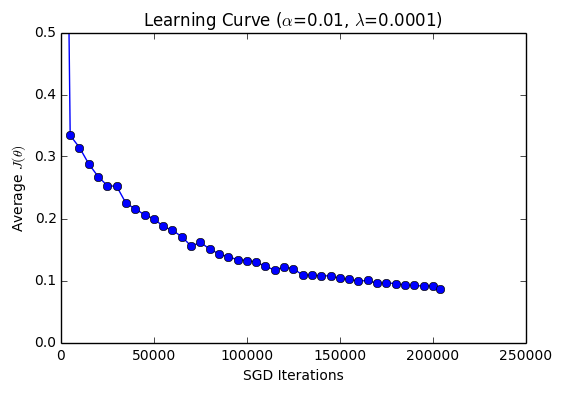

In [22]:
##
# Plot your best learning curve here
counts, costs = zip(*traincurvebest)
figure(figsize=(6,4))
plot(5*array(counts), costs, color='b', marker='o', linestyle='-')
title(r"Learning Curve ($\alpha$=%g, $\lambda$=%g)" % (clf.alpha, clf.lreg))
xlabel("SGD Iterations"); ylabel(r"Average $J(\theta)$"); 
ylim(ymin=0, ymax=max(1.1*max(costs),3*min(costs)));
ylim(0,0.5)

# Don't change this filename!
savefig("ner.learningcurve.best.png")

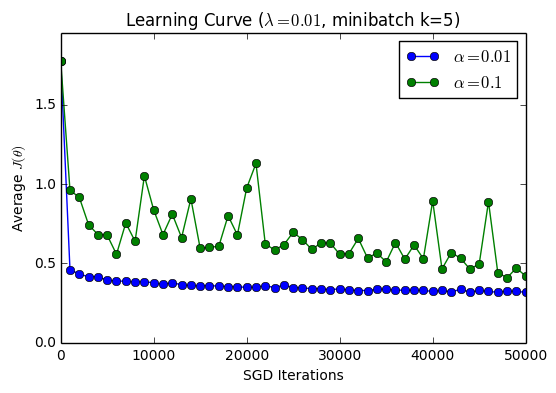

In [25]:
##
# Plot comparison of learning rates here
# feel free to change the code below

figure(figsize=(6,4))
counts, costs = zip(*trainingcurve1)
plot(5*array(counts), costs, color='b', marker='o', linestyle='-', label=r"$\alpha=0.01$")
counts, costs = zip(*trainingcurve2)
plot(5*array(counts), costs, color='g', marker='o', linestyle='-', label=r"$\alpha=0.1$")
title(r"Learning Curve ($\lambda=0.01$, minibatch k=5)")
xlabel("SGD Iterations"); ylabel(r"Average $J(\theta)$"); 
ylim(ymin=0, ymax=max(1.1*max(costs),3*min(costs)));
legend()

# Don't change this filename
savefig("ner.learningcurve.comparison.png")

## (f): Evaluating your model
Evaluate the model on the dev set using your `predict` function, and compute performance metrics below!

In [26]:
# Predict labels on the dev set
yp = clf.predict(X_dev)
# Save predictions to a file, one per line
ner.save_predictions(yp, "dev.predicted")

In [27]:
from nerwindow import full_report, eval_performance
full_report(y_dev, yp, tagnames) # full report, helpful diagnostics
eval_performance(y_dev, yp, tagnames) # performance: optimize this F1

             precision    recall  f1-score   support

          O       0.97      0.99      0.98     42759
        LOC       0.90      0.83      0.86      2094
       MISC       0.87      0.72      0.79      1268
        ORG       0.77      0.63      0.69      2092
        PER       0.86      0.87      0.87      3149

avg / total       0.95      0.95      0.95     51362

=== Performance (omitting 'O' class) ===
Mean precision:  85.11%
Mean recall:     78.00%
Mean F1:         81.24%


In [28]:
# Save your predictions on the test set for us to evaluate
# IMPORTANT: make sure X_test is exactly as loaded 
# from du.docs_to_windows, so that your predictions 
# line up with ours.
yptest = clf.predict(X_test)
ner.save_predictions(yptest, "test.predicted")

## Part [1.1]: Probing neuron responses

You might have seen some results from computer vision where the individual neurons learn to detect edges, shapes, or even [cat faces](http://googleblog.blogspot.com/2012/06/using-large-scale-brain-simulations-for.html). We're going to do the same for language.

Recall that each "neuron" is essentially a logistic regression unit, with weights corresponding to rows of the corresponding matrix. So, if we have a hidden layer of dimension 100, then we can think of our matrix $W \in \mathbb{R}^{100 x 150}$ as representing 100 hidden neurons each with weights `W[i,:]` and bias `b1[i]`.

### (a): Hidden Layer, Center Word
For now, let's just look at the center word, and ignore the rest of the window. This corresponds to columns `W[:,50:100]`, although this could change if you altered the window size for your model. For each neuron, find the top 10 words that it responds to, as measured by the dot product between `W[i,50:100]` and `L[j]`. Use the provided code to print these words and their scores for 5 neurons of your choice. In your writeup, briefly describe what you notice here.

The `num_to_word` dictionary, loaded earlier, may be helpful.

In [39]:
# Recommended function to print scores
# scores = list of float
# words = list of str
def print_scores(scores, words):
    for i in range(len(scores)):
        print "[%d]: (%.03f) %s" % (i, scores[i], words[i])

#### YOUR CODE HERE ####
# W[i,50:100] is（50, ）, L is |V| x 50
neurons = [7,17,57,77,87] # change this to your chosen neurons
for i in neurons:
    print "Neuron %d" % i
    score = dot(clf.sparams.L, clf.params.W[i,50:100])
    index = argsort(score)[-10:][::-1]
    print  index
    topscores = [score[i] for i in index]
    topwords = [num_to_word[i] for i in index]
    print_scores(topscores, topwords)
    
#### END YOUR CODE ####

Neuron 7
[ 7078  4227  5071    69  6612 15615  2008  6505  3862  3268]
[0]: (2.882) trapped
[1]: (2.621) suddenly
[2]: (2.561) shelter
[3]: (2.339) can
[4]: (2.314) deeply
[5]: (2.300) cleaner
[6]: (2.212) partner
[7]: (2.196) accidentally
[8]: (2.186) 'd
[9]: (2.141) carbon
Neuron 17
[  59 6714 1743   47 4013 2039 8817 2733  239 7666]
[0]: (0.692) there
[1]: (0.457) scope
[2]: (0.433) planning
[3]: (0.407) who
[4]: (0.401) difficulty
[5]: (0.401) heritage
[6]: (0.395) sociology
[7]: (0.394) map
[8]: (0.380) what
[9]: (0.375) geology
Neuron 57
[  59   45  696   34   47   69   31  589 2509  148]
[0]: (1.401) there
[1]: (1.223) they
[2]: (1.173) whose
[3]: (1.150) or
[4]: (1.094) who
[5]: (1.074) can
[6]: (1.070) </s>
[7]: (1.050) close
[8]: (1.043) hence
[9]: (1.033) i
Neuron 77
[ 3370 24506 23781 35770  5210  8551  2674 39431  4515 20007]
[0]: (1.193) carter
[1]: (1.156) gaze
[2]: (1.111) superficially
[3]: (1.079) powerfully
[4]: (1.075) pierce
[5]: (1.075) alike
[6]: (1.014) moore
[7

### (b): Model Output, Center Word
Now, let's do the same for the output layer. Here we only have 5 neurons, one for each class. `O` isn't very interesting, but let's look at the other four.

Here things get a little more complicated: since we take a softmax, we can't just look at the neurons separately. An input could cause several of these neurons to all have a strong response, so we really need to compute the softmax output and find the strongest inputs for each class.

As before, let's consider only the center word (`W[:,50:100]`). For each class `ORG`, `PER`, `LOC`, and `MISC`, find the input words that give the highest probability $P(\text{class}\ |\ \text{word})$.

You'll need to do the full feed-forward computation here - for efficiency, try to express this as a matrix operation on $L$. This is the same feed-forward computation as used to predict probabilities, just with $W$ replaced by `W[:,50:100]`.

As with the hidden-layer neurons, print the top 10 words and their corresponding class probabilities for each class.

In [43]:
#### YOUR CODE HERE ####
def softmax_axis1(x):
    x_shape = x.shape

    row_max = amax(x, axis=1).reshape((x.shape[0], 1))
    x = np.exp(x - row_max)
    row_sums = sum(x, axis=1).reshape((x.shape[0], 1))
    x = x / row_sums
    x = x.reshape(x_shape)
    
    return x

from nn.math import softmax, make_onehot, sigmoid
print clf.sparams.L.shape, clf.params.W[:, 50:100].shape
z1 = dot(clf.sparams.L, clf.params.W[:, 50:100].T) + clf.params.b1
print z1.shape
print clf.params.U.shape, clf.params.b2.shape
h = 2.0*sigmoid(2.0*z1) - 1.0
z2 = dot(h, clf.params.U.T) + clf.params.b2
print z2.shape
p = softmax_axis1(z2)

for i in range(1,5):
    # prob = softmax(z2[:,i])
    prob = p[:,i]
    print "Output neuron %d: %s" % (i, num_to_tag[i])
    index = argsort(prob)[-10:][::-1] # index of max ten possibility
    topprobs = [prob[i] for i in index]
    topwords = [num_to_word[i] for i in index]
    print_scores(topprobs, topwords)
    print " "

#### END YOUR CODE ####

(100232, 50) (125, 50)
(100232, 125)
(5, 125) (5,)
(100232, 5)
Output neuron 1: LOC
[0]: (0.998) italy
[1]: (0.998) dune
[2]: (0.998) egypt
[3]: (0.998) norway
[4]: (0.997) malaysia
[5]: (0.997) headland
[6]: (0.996) zimbabwe
[7]: (0.996) lanka
[8]: (0.996) switzerland
[9]: (0.994) rica
 
Output neuron 2: MISC
[0]: (1.000) italian
[1]: (1.000) danish
[2]: (1.000) israeli
[3]: (1.000) brazilian
[4]: (1.000) turkish
[5]: (1.000) german
[6]: (1.000) palestinians
[7]: (0.999) egyptian
[8]: (0.999) english
[9]: (0.999) serb
 
Output neuron 3: ORG
[0]: (1.000) corp
[1]: (1.000) commons
[2]: (1.000) inc
[3]: (1.000) microsoft
[4]: (1.000) faire
[5]: (1.000) maple
[6]: (1.000) combine
[7]: (1.000) tidewater
[8]: (1.000) zenith
[9]: (1.000) ajax
 
Output neuron 4: PER
[0]: (1.000) innocence
[1]: (1.000) martin
[2]: (1.000) herb
[3]: (1.000) pat
[4]: (1.000) stephen
[5]: (1.000) jim
[6]: (1.000) buck
[7]: (1.000) thompson
[8]: (1.000) laughter
[9]: (1.000) norman
 


### (c): Model Output, Preceding Word
Now for one final task: let's look at the preceding word. Repeat the above analysis for the output layer, but use the first part of $W$, i.e. `W[:,:50]`.

Describe what you see, and include these results in your writeup.

In [44]:
#### YOUR CODE HERE ####
z1 = dot(clf.sparams.L, clf.params.W[:, :50].T) + clf.params.b1
print z1.shape
print clf.params.U.shape, clf.params.b2.shape
h = 2.0*sigmoid(2.0*z1) - 1.0
z2 = dot(h, clf.params.U.T) + clf.params.b2
print z2.shape
p = softmax_axis1(z2)

for i in range(1,5):
    # prob = softmax(z2[:,i])
    prob = p[:,i]
    print "Output neuron %d: %s" % (i, num_to_tag[i])
    index = argsort(prob)[-10:][::-1] # index of max ten possibility
    topprobs = [prob[i] for i in index]
    topwords = [num_to_word[i] for i in index]
    print_scores(topprobs, topwords)
    print " "
#### END YOUR CODE ####

(100232, 125)
(5, 125) (5,)
(100232, 5)
Output neuron 1: LOC
[0]: (0.579) mountains
[1]: (0.547) visited
[2]: (0.482) west
[3]: (0.455) east
[4]: (0.424) joins
[5]: (0.379) enters
[6]: (0.375) lake
[7]: (0.338) near
[8]: (0.325) adjacent
[9]: (0.318) inland
 
Output neuron 2: MISC
[0]: (0.684) </s>
[1]: (0.616) island
[2]: (0.494) century
[3]: (0.470) series
[4]: (0.448) al
[5]: (0.434) cave
[6]: (0.428) dune
[7]: (0.398) atoll
[8]: (0.388) county
[9]: (0.364) new
 
Output neuron 3: ORG
[0]: (0.997) enterprise
[1]: (0.996) dream
[2]: (0.995) magic
[3]: (0.991) grove
[4]: (0.989) &
[5]: (0.989) venture
[6]: (0.987) corporation
[7]: (0.985) faire
[8]: (0.985) thunder
[9]: (0.981) cosmology
 
Output neuron 4: PER
[0]: (1.000) pat
[1]: (1.000) climber
[2]: (1.000) matt
[3]: (1.000) egotistical
[4]: (1.000) aunt
[5]: (1.000) mate
[6]: (1.000) stephen
[7]: (1.000) peter
[8]: (1.000) irascible
[9]: (1.000) bob
 
